# Решение кейса определения объема кучи щебня на видео
Что мы имеем?
- Плохие данные, т.е. все серое, кучи не видно практически, 
всего два видео с двумя кучами в сумме на 7 минут
- масштаб на видео меняется
- отсутсвтие значений объемов обеих куч

Ход решения:
- раскадровка видео с помощью PIL
- Первая сверточная сеть для поиска кадра, где куча есть полностью(классификация/сегментация)
- Вторая предобученная свёрточная сеть для определения масштаба кучи
(на видео есть маркеры, между которыми 3 метра и за 100% мы взяли захват экрана 28 метров)(регрессия)
- Третья сеть, которая определяется по масштабу и картинке кучи ее объем(регрессия)

Ниже представлена сеть для определения масштаба кучи

Особенности:
- Данные пришлось размечать вручную, для этого мы использовали временные отрезки, где есть куча/нет кучи для первой сети
и по времени эти интервалы представили с помощью one_hot encoding
- Для второй сети так же данные размечали вручную, масштаб менялся каждую секунду, т.ее у дрона были взлеты и посадки, поэтому мы взяли за основу интервалы, где дрон летает дольше на одних и тех дже высотах и между ними для каждой секунды сделали линейный переход
- Для датасета брали каждый 30 кадр из видео 30fps
- Хотел использовать сегментацию для определения площади основания кучи и возможно площади среза(так называемого конуса), а дальше уже уже через формулу определения объема усеченного консу(picture 1) + формулу определения объема кучи, не известно, что было бы точнее, но с целью обобщения результатов можно хотел бы между ними взять среднее или посчитать их значение, но больший вес отдать формуле объема кучи

* Высоту дрона на каждом кадре мы брали из метаданных к видео


picture 1
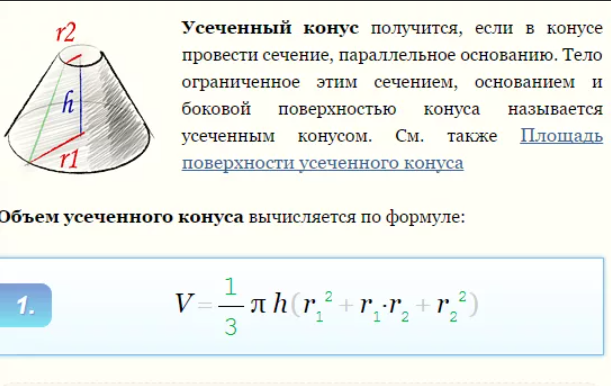
picture 2
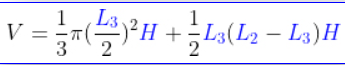

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 50.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from google.colab import drive

from pathlib import Path
from PIL import Image
import cv2

import shutil
import os
import re

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input


%matplotlib inline
# drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/train_data.zip' -d '/content/frames/'

Archive:  /content/drive/MyDrive/train_data.zip
   creating: /content/frames/content/frames/train/
   creating: /content/frames/content/frames/train/104/
  inflating: /content/frames/content/frames/train/104/s3130.jpg  
  inflating: /content/frames/content/frames/train/104/b3130.jpg  
  inflating: /content/frames/content/frames/train/104/b1640.jpg  
  inflating: /content/frames/content/frames/train/104/s1630.jpg  
  inflating: /content/frames/content/frames/train/104/b3120.jpg  
  inflating: /content/frames/content/frames/train/104/b1630.jpg  
  inflating: /content/frames/content/frames/train/104/s1640.jpg  
  inflating: /content/frames/content/frames/train/104/s3110.jpg  
  inflating: /content/frames/content/frames/train/104/s3120.jpg  
  inflating: /content/frames/content/frames/train/104/b3110.jpg  
   creating: /content/frames/content/frames/train/119/
  inflating: /content/frames/content/frames/train/119/b2750.jpg  
  inflating: /content/frames/content/frames/train/119/s1950.jpg  

In [ ]:
base_dir = Path('/content/')
frames_child = base_dir / 'frames/frames_s_b'
frames_parent = base_dir / 'frames'

big_data = base_dir / 'frames/frames_s_b/big'
small_data = base_dir / 'frames/frames_s_b/small'

scale_big_csv = base_dir / 'scale_big.csv'
scale_small_csv = base_dir / 'scale_small.csv'

In [ ]:
def makes_dirs_categorical(frames_child):
  """
  Разбивает все файлы вложенных каталого на папки
  по совпадению числа из названия картинки с колонкой в pandas
  """
  for directory in os.listdir(frames_child):
    print(directory)
    for file in os.listdir(frames_child / directory):
      num_frame = re.findall(r'\d+', file)[0]
      #условие выбора названия папки
      current_scale = df_big.loc[df_big['second'] == int(num_frame)]['scale'].to_numpy()  #выводит
      if current_scale:
        find_dir = base_dir / f'/content/frames/train/{current_scale[0]}'
        if not os.path.isdir(find_dir):
          os.makedirs(find_dir)
        shutil.move(frames_child / directory / file, find_dir / file)

# makes_dirs_categorical(frames_child)

In [ ]:
df_big_base = pd.read_csv(scale_big_csv)
df_small_base = pd.read_csv(scale_small_csv)

df_small, df_big = df_small_base[['second', 'scale']], df_big_base[['second', 'scale']]
df_big

,second,scale
0,0,100
1,10,100
2,20,100
3,30,100
4,40,100
...,...,...
583,5830,75
584,5840,75
585,5850,75
586,5860,75


In [ ]:
# shutil.rmtree('/content/frames/train/frames_s_b')

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 600, 1000
BATCH_SIZE = 32
frames_parent = Path('/content/frames/content/frames/')

image_gen_train = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = "nearest", zoom_range = 0.2,
    width_shift_range = 0.2, height_shift_range=0.2,
    rotation_range=30,
    validation_split=0.2,
    preprocessing_function=preprocess_input
    )

train_flow = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=frames_parent / 'train',
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='sparse',
    subset='training'
    )

val_flow = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=frames_parent / 'train',
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='sparse',
    subset='validation',
    )

Found 966 images belonging to 51 classes.
Found 210 images belonging to 51 classes.


Что я буду использовать:
- train and validation data, созданные классом ImageDataGenerator
- Архитектуру ResNet50 c обученными весами на ImageNet датасете
- обучать последние 5 слоев
- Планировщик шага спуска с коэффициентов exp**-0.1
- в конце один полносвязный слой с одним выходом без активации для задачи регрессии
- чекпоинт для сохранения модели
- loss - rmsprop
- метрику mae для наглядного предствления ошибки

In [ ]:
class Regressor:
  def __init__(self):
    self.IMG_SHAPE = train_flow.image_shape
    self.base_model = tf.keras.applications.ResNet50(input_shape=self.IMG_SHAPE, weights='imagenet', include_top=False) #
    self.base_model.trainable = False
    self.epoch_start_schedule = 3


  def unfreeze(self):
    self.base_model.trainable = True
    print("Количество слоев в базовой модели: ", len(self.base_model.layers), '\n')

    fine_tune_at = len(self.base_model.layers) - 5
    for layer in self.base_model.layers[:fine_tune_at]:
      layer.trainable =  False


  def scheduler(self, epoch, lr):
   if epoch < self.epoch_start_schedule:
     return lr
   else:
     return lr * tf.math.exp(-0.1)


  def extra_layers(self, metrics, optimizer, loss):
    self.model = tf.keras.Sequential([
      self.base_model,
      tf.keras.layers.Dense(1)
    ])

    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print('!the model was built with additional layers!\n')


  def fit_train(self, epochs, train_data_gen, val_data_gen=None):
    callback_schedule = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
    сheckpoint = tf.keras.callbacks.ModelCheckpoint(
      '/content/efficentnetV2M-hack.hdf5', 
      monitor='val_mae', 
      save_best_only=True
    )
    
    self.hist = self.model.fit(
      train_data_gen,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=[сheckpoint, callback_schedule]
    )


  def fit_vizualization(self):
    plt.plot(self.hist.history['mae'])
    plt.plot(self.hist.history['val_mae'])


  def predict_value(self, datagen):
    pass

In [ ]:
hack = Regressor()
hack.unfreeze()

Количество слоев в базовой модели:  175 



In [ ]:
%%time

hack.extra_layers(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005),
    loss='mse',
    metrics=['mae']
)

hack.fit_train(
    train_data_gen=train_flow,
    val_data_gen=val_flow,
    epochs=5
    )

!the model was built with additional layers!

Epoch 1/5
31/31 [==============================] - 104s 3s/step - loss: 226.1162 - mae: 12.5265 - val_loss: 173.7525 - val_mae: 12.0705 - lr: 0.0050
Epoch 2/5
31/31 [==============================] - 102s 3s/step - loss: 186.3664 - mae: 11.8266 - val_loss: 152.6456 - val_mae: 11.2945 - lr: 0.0050
Epoch 3/5
31/31 [==============================] - 95s 3s/step - loss: 185.4196 - mae: 11.8579 - val_loss: 187.1184 - val_mae: 11.0141 - lr: 0.0050
Epoch 4/5
31/31 [==============================] - 95s 3s/step - loss: 184.5349 - mae: 11.7880 - val_loss: 163.1707 - val_mae: 12.0283 - lr: 0.0045
Epoch 5/5
31/31 [==============================] - 95s 3s/step - loss: 182.7224 - mae: 11.8396 - val_loss: 155.7477 - val_mae: 10.7886 - lr: 0.0041
CPU times: user 8min 1s, sys: 16.3 s, total: 8min 18s
Wall time: 8min 54s


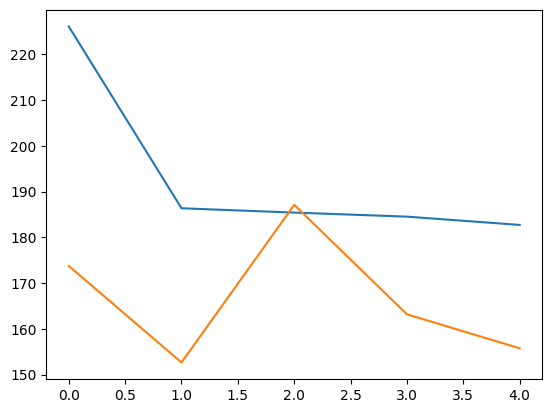

In [ ]:
hack.fit_vizualization()

Наше отклонение MAE дает нам понять, что в среднем на 10% отклоняется нашего значение, т.е. это около 2-3 метров разницы в масштабе, достаточно хороший результат для последующей обработки